# ML Assignment 1

Data set 1 - Bank Account Fraud Dataset \
https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022 \
Data set 2 - Customer Segmentation \
https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation?select=train.csv


In [1]:
# Load function and data

In [2]:
%run ./ML_assignment1_Functions.ipynb

In [3]:
# Data set 1
# Neural Network

In [4]:
from sklearn.neighbors import KNeighborsClassifier
# load data
df = load_data('Base.csv')
df.shape

(5000, 32)

In [5]:
## model1.1 - KNN with Feature engineering
# n_neighbors
# Number of neighbors to use by default for k neighbors queries.
# Weigths
# ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
# ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

In [6]:
# train valid test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df)
# feature engineering
X_train, X_valid, X_test = ohe(X_train, X_valid, X_test)
# oversampling
X_train, y_train = oversampling(X_train, y_train)
# model
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)
knn_fe = model(knn, X_train, y_train, X_valid, y_valid)
knn_fe['n_neighbors'] =  str(5)
knn_fe['weights'] = 'uniform'
knn_fe['name'] = 'knn_Feature_engineering'
knn_fe

,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,n_neighbors,weights,name
0,0.652,0.756,0.83,0.587,0.652,0.657,2.48438,5,uniform,knn_Feature_engineering


In [7]:
## model1.2 - KNN with tuning layers and activation

In [8]:
# train valid test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df)
# feature engineering
X_train, X_valid, X_test = ohe(X_train, X_valid, X_test)
# oversampling
X_train, y_train = oversampling(X_train, y_train)
# model
params = {'n_neighbors': [2,5,7,10], 
          'weights': ['uniform','distance']
         }
knn_tune_perf = pd.DataFrame()
for x in params['n_neighbors']:
    for y in params['weights']:
        knn = KNeighborsClassifier(n_neighbors=x, weights=y)
        knn_tune = model(knn, X_train, y_train, X_valid, y_valid)
        knn_tune['n_neighbors'] =  str(x)
        knn_tune['weights'] = y
        knn_tune_perf = knn_tune_perf.append(knn_tune)

knn_tune_perf['name'] = 'knn_tune'
knn_tune_perf

,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,n_neighbors,weights,name
0,0.642,0.775,0.976,0.621,0.642,0.657,2.01562,2,uniform,knn_tune
0,0.634,0.845,1.000,0.624,0.634,0.650,0.65625,2,distance,knn_tune
0,0.652,0.756,0.830,0.587,0.652,0.657,2.70312,5,uniform,knn_tune
0,0.659,0.810,1.000,0.532,0.659,0.636,1.15625,5,distance,knn_tune
0,0.621,0.751,0.807,0.677,0.621,0.638,1.81250,7,uniform,knn_tune
0,0.634,0.803,1.000,0.624,0.634,0.650,1.35938,7,distance,knn_tune
0,0.628,0.740,0.793,0.684,0.628,0.644,2.45312,10,uniform,knn_tune
0,0.634,0.795,1.000,0.624,0.634,0.650,0.75000,10,distance,knn_tune


In [9]:
## model1.3 - KNN with Grid Search

In [10]:
# train valid test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df)
# feature engineering
X_train, X_valid, X_test = ohe(X_train, X_valid, X_test)
# oversampling
X_train, y_train = oversampling(X_train, y_train)
# model

t_start = process_time()
params = {'n_neighbors': range(2,15,2), 
          'weights': ['uniform','distance']
         }
knn = GridSearchCV(KNeighborsClassifier(), params, scoring='roc_auc', cv=10, n_jobs=-1)
knn.fit(X=X_train, y=y_train)
t_stop = process_time()
print (knn.best_score_, knn.best_params_, 'time spend: ', round(t_stop - t_start, 3)) 
nei = knn.best_params_['n_neighbors']
wei = knn.best_params_['weights']

0.975735969110817 {'n_neighbors': 14, 'weights': 'distance'} time spend:  0.516


In [11]:
knn = KNeighborsClassifier( n_neighbors = nei, weights = wei)
knn_gs_perf = model(knn, X_train, y_train, X_valid, y_valid)
knn_gs_perf['n_neighbors'] =  str(nei)
knn_gs_perf['weights'] = wei
knn_gs_perf['name'] = 'knn_grid_search'
knn_gs_perf

,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,n_neighbors,weights,name
0,0.634,0.789,1.0,0.624,0.634,0.65,0.9375,14,distance,knn_grid_search


In [12]:
# model4 - KNN with learning curve

In [13]:
# train valid test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df)
# create an empty df for output
knn_lc_perf_out = pd.DataFrame()
for r in [0.1, 0.2,0.3, 0.4, 0.5,0.6, 0.7,0.8,0.9,1.0]:
    # frac train set to build model
#     print(len(X_train))
    X_trainf = X_train.sample(frac = r, random_state=0)
    y_trainf = y_train.loc[X_trainf.index]
    
#     print(len(X_trainf), len(y_trainf))
    # feature engineering
    X_trainf, X_valid, X_test = ohe(X_trainf, X_valid, X_test)
    # oversampling
    X_trainf, y_trainf = oversampling(X_trainf, y_trainf)
    # model
    knn =  KNeighborsClassifier(n_neighbors=nei, weights=wei)
    
    lc_perf = model(knn, X_trainf, y_trainf, X_valid, y_valid)
    # add columns
    lc_perf['train_ratio'] = str(r)
    lc_perf['n_neighbors'] =  str(nei)
    lc_perf['weights'] = wei
    lc_perf['name'] = 'knn_train_size'
    knn_lc_perf_out = knn_lc_perf_out.append(lc_perf)
    
knn_lc_perf_out

,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,train_ratio,n_neighbors,weights,name
0,0.754,0.785,0.838,0.712,0.754,0.757,0.01562,0.1,14,distance,knn_train_size
0,0.841,0.780,0.811,0.758,0.841,0.831,0.01562,0.2,14,distance,knn_train_size
0,0.914,0.884,0.896,0.854,0.914,0.909,0.03125,0.3,14,distance,knn_train_size
0,0.969,0.957,0.955,0.949,0.969,0.968,0.04688,0.4,14,distance,knn_train_size
0,0.955,0.980,1.000,0.962,0.955,0.956,0.04688,0.5,14,distance,knn_train_size
0,0.856,0.940,1.000,0.873,0.856,0.861,0.10938,0.6,14,distance,knn_train_size
0,0.782,0.895,1.000,0.803,0.782,0.792,0.10938,0.7,14,distance,knn_train_size
0,0.732,0.853,1.000,0.739,0.732,0.744,0.09375,0.8,14,distance,knn_train_size
0,0.684,0.812,1.000,0.688,0.684,0.698,0.60938,0.9,14,distance,knn_train_size
0,0.711,0.787,1.000,0.592,0.711,0.690,0.75000,1.0,14,distance,knn_train_size


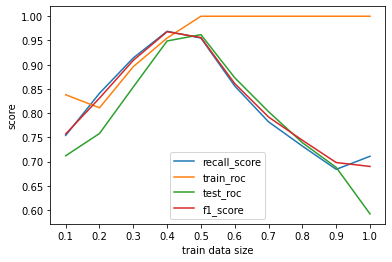

In [14]:
learning_curve_graph(knn_lc_perf_out)

In [15]:
# KNN test set output

In [16]:
# train valid test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df)
# feature engineering
X_train, X_valid, X_test = ohe(X_train, X_valid, X_test)
# oversampling
X_train, y_train = oversampling(X_train, y_train)
# model
knn =  KNeighborsClassifier(n_neighbors=nei, weights=wei)
knn.fit(X_train, y_train)
knn_test_perf = model(knn, X_train, y_train, X_test, y_test)
knn_test_perf['n_neighbors'] =  str(nei)
knn_test_perf['weights'] = wei
knn_test_perf['name'] = 'knn_test'
knn_test_perf

,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,n_neighbors,weights,name
0,0.67,0.789,1.0,0.659,0.67,0.683,0.85938,14,distance,knn_test


In [17]:
knn_performance = pd.DataFrame()
knn_performance=knn_performance.append([knn_fe,knn_tune_perf,knn_gs_perf,knn_lc_perf_out,knn_test_perf]).reset_index()
knn_performance

,index,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,n_neighbors,weights,name,train_ratio
0,0,0.652,0.756,0.830,0.587,0.652,0.657,2.48438,5,uniform,knn_Feature_engineering,NaN
1,0,0.642,0.775,0.976,0.621,0.642,0.657,2.01562,2,uniform,knn_tune,NaN
2,0,0.634,0.845,1.000,0.624,0.634,0.650,0.65625,2,distance,knn_tune,NaN
3,0,0.652,0.756,0.830,0.587,0.652,0.657,2.70312,5,uniform,knn_tune,NaN
4,0,0.659,0.810,1.000,0.532,0.659,0.636,1.15625,5,distance,knn_tune,NaN
5,0,0.621,0.751,0.807,0.677,0.621,0.638,1.81250,7,uniform,knn_tune,NaN
6,0,0.634,0.803,1.000,0.624,0.634,0.650,1.35938,7,distance,knn_tune,NaN
7,0,0.628,0.740,0.793,0.684,0.628,0.644,2.45312,10,uniform,knn_tune,NaN
8,0,0.634,0.795,1.000,0.624,0.634,0.650,0.75000,10,distance,knn_tune,NaN
9,0,0.634,0.789,1.000,0.624,0.634,0.650,0.93750,14,distance,knn_grid_search,NaN


In [18]:
knn_performance.to_excel('./performance/knn_perf_data1.xlsx',index=False)

# Data 2

In [19]:
from sklearn.neighbors import KNeighborsClassifier
# load data
df = load_data('customer_segment.csv')
df.drop(columns= ['ID'],inplace=True)
# transform target variable
from sklearn.preprocessing import LabelEncoder
df.Segmentation=LabelEncoder().fit_transform(df.Segmentation)

In [20]:
## model2.1 - KNN with Feature engineering

In [21]:
# train valid test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split2(df)
# feature engineering
X_train, X_valid, X_test = ohe(X_train, X_valid, X_test)
# model
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)
knn_fe = model2(knn, X_train, y_train, X_valid, y_valid)
knn_fe['n_neighbors'] =  str(5)
knn_fe['weights'] = 'uniform'
knn_fe['name'] = 'knn_Feature_engineering'
knn_fe

,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,n_neighbors,weights,name
0,0.396,0.39,0.829,0.676,0.396,0.397,0.406,5,uniform,knn_Feature_engineering


In [22]:
## model2.2 - KNN with tuning layers and activation

In [23]:
# train valid test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split2(df)
# feature engineering
X_train, X_valid, X_test = ohe(X_train, X_valid, X_test)
# model
params = {'n_neighbors': [2,5,7,10], 
          'weights': ['uniform','distance']
         }
knn_tune_perf = pd.DataFrame()
for x in params['n_neighbors']:
    for y in params['weights']:
        knn = KNeighborsClassifier(n_neighbors=x, weights=y)
        knn_tune = model2(knn, X_train, y_train, X_valid, y_valid)
        knn_tune['n_neighbors'] =  str(x)
        knn_tune['weights'] = y
        knn_tune_perf = knn_tune_perf.append(knn_tune)

knn_tune_perf['name'] = 'knn_tune'
knn_tune_perf

,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,n_neighbors,weights,name
0,0.331,0.335,0.874,0.630,0.331,0.333,0.609,2,uniform,knn_tune
0,0.372,0.364,0.944,0.631,0.372,0.373,0.125,2,distance,knn_tune
0,0.396,0.390,0.829,0.676,0.396,0.397,1.000,5,uniform,knn_tune
0,0.415,0.406,0.979,0.674,0.415,0.408,0.125,5,distance,knn_tune
0,0.424,0.396,0.812,0.685,0.424,0.420,0.484,7,uniform,knn_tune
0,0.414,0.401,0.983,0.681,0.414,0.407,0.188,7,distance,knn_tune
0,0.425,0.406,0.792,0.695,0.425,0.419,0.406,10,uniform,knn_tune
0,0.425,0.409,0.985,0.686,0.425,0.417,0.125,10,distance,knn_tune


In [24]:
## model2.3 - KNN with Grid Search

In [25]:
# train valid test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split2(df)
# feature engineering
X_train, X_valid, X_test = ohe(X_train, X_valid, X_test)
# model

t_start = process_time()
params = {'n_neighbors': range(2,50,2), 
          'weights': ['uniform','distance']
         }
from sklearn.metrics import make_scorer,roc_auc_score
score = {'auc': make_scorer(roc_auc_score, needs_proba=True, multi_class="ovr")}
knn = GridSearchCV(KNeighborsClassifier(), params, scoring=score['auc'], n_jobs=-1, cv=3)
knn.fit(X=X_train, y=y_train)
t_stop = process_time()
print (knn.best_score_, knn.best_params_, 'time spend: ', round(t_stop - t_start, 3)) 
nei = knn.best_params_['n_neighbors']
wei = knn.best_params_['weights']

0.6630803447601213 {'n_neighbors': 22, 'weights': 'uniform'} time spend:  0.219


In [26]:
knn = KNeighborsClassifier( n_neighbors = nei, weights = wei)
knn_gs_perf = model2(knn, X_train, y_train, X_valid, y_valid)
knn_gs_perf['n_neighbors'] =  str(nei)
knn_gs_perf['weights'] = wei
knn_gs_perf['name'] = 'knn_grid_search'
knn_gs_perf

,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,n_neighbors,weights,name
0,0.429,0.414,0.754,0.692,0.429,0.419,0.641,22,uniform,knn_grid_search


In [27]:
# model2.4 - KNN with learning curve

In [28]:
# train valid test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split2(df)
# create an empty df for output
knn_lc_perf_out = pd.DataFrame()
for r in [0.1, 0.2,0.3, 0.4, 0.5,0.6, 0.7,0.8,0.9,1.0]:
    # frac train set to build model
#     print(len(X_train))
    X_trainf = X_train.sample(frac = r, random_state=0)
    y_trainf = y_train.loc[X_trainf.index]
    
#     print(len(X_trainf), len(y_trainf))
    # feature engineering
    X_trainf, X_valid, X_test = ohe(X_trainf, X_valid, X_test)
    # model
    knn =  KNeighborsClassifier(n_neighbors=nei, weights=wei)
    
    lc_perf = model2(knn, X_trainf, y_trainf, X_valid, y_valid)
    # add columns
    lc_perf['train_ratio'] = str(r)
    lc_perf['n_neighbors'] =  str(nei)
    lc_perf['weights'] = wei
    lc_perf['name'] = 'knn_train_size'
    knn_lc_perf_out = knn_lc_perf_out.append(lc_perf)
    
knn_lc_perf_out

,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,train_ratio,n_neighbors,weights,name
0,0.448,0.422,0.779,0.735,0.448,0.433,0.016,0.1,22,uniform,knn_train_size
0,0.436,0.430,0.775,0.727,0.436,0.428,0.047,0.2,22,uniform,knn_train_size
0,0.440,0.418,0.769,0.732,0.440,0.431,0.078,0.3,22,uniform,knn_train_size
0,0.451,0.416,0.762,0.730,0.451,0.446,0.078,0.4,22,uniform,knn_train_size
0,0.432,0.406,0.756,0.718,0.432,0.425,0.141,0.5,22,uniform,knn_train_size
0,0.432,0.395,0.754,0.710,0.432,0.434,0.297,0.6,22,uniform,knn_train_size
0,0.431,0.408,0.753,0.704,0.431,0.422,0.188,0.7,22,uniform,knn_train_size
0,0.444,0.405,0.755,0.704,0.444,0.429,0.266,0.8,22,uniform,knn_train_size
0,0.440,0.399,0.756,0.704,0.440,0.429,0.609,0.9,22,uniform,knn_train_size
0,0.428,0.418,0.766,0.688,0.428,0.413,0.516,1.0,22,uniform,knn_train_size


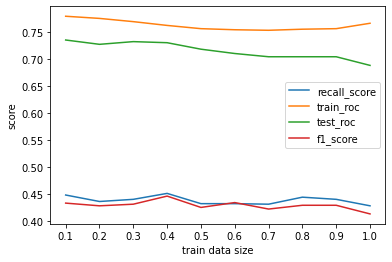

In [29]:
learning_curve_graph(knn_lc_perf_out)

In [30]:
# KNN test set output

In [31]:
# train valid test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split2(df)
# feature engineering
X_train, X_valid, X_test = ohe(X_train, X_valid, X_test)
# model
knn =  KNeighborsClassifier(n_neighbors=nei, weights=wei)
knn.fit(X_train, y_train)
knn_test_perf = model2(knn, X_train, y_train, X_test, y_test)
knn_test_perf['n_neighbors'] =  str(nei)
knn_test_perf['weights'] = wei
knn_test_perf['name'] = 'knn_test'
knn_test_perf

,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,n_neighbors,weights,name
0,0.413,0.414,0.754,0.68,0.413,0.398,0.656,22,uniform,knn_test


In [32]:
knn_performance = pd.DataFrame()
knn_performance=knn_performance.append([knn_fe,knn_tune_perf,knn_gs_perf,knn_lc_perf_out,knn_test_perf]).reset_index()
knn_performance

,index,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,n_neighbors,weights,name,train_ratio
0,0,0.396,0.390,0.829,0.676,0.396,0.397,0.406,5,uniform,knn_Feature_engineering,NaN
1,0,0.331,0.335,0.874,0.630,0.331,0.333,0.609,2,uniform,knn_tune,NaN
2,0,0.372,0.364,0.944,0.631,0.372,0.373,0.125,2,distance,knn_tune,NaN
3,0,0.396,0.390,0.829,0.676,0.396,0.397,1.000,5,uniform,knn_tune,NaN
4,0,0.415,0.406,0.979,0.674,0.415,0.408,0.125,5,distance,knn_tune,NaN
5,0,0.424,0.396,0.812,0.685,0.424,0.420,0.484,7,uniform,knn_tune,NaN
6,0,0.414,0.401,0.983,0.681,0.414,0.407,0.188,7,distance,knn_tune,NaN
7,0,0.425,0.406,0.792,0.695,0.425,0.419,0.406,10,uniform,knn_tune,NaN
8,0,0.425,0.409,0.985,0.686,0.425,0.417,0.125,10,distance,knn_tune,NaN
9,0,0.429,0.414,0.754,0.692,0.429,0.419,0.641,22,uniform,knn_grid_search,NaN


In [33]:
knn_performance.to_excel('./performance/knn_perf_data2.xlsx',index=False)